In [1]:
"""
Exploratory data analysis for the weather-airports project.

Weather data: https://www.kaggle.com/sobhanmoosavi/us-weather-events
Flight delays/cancellations: https://www.transtats.bts.gov/DL_SelectFields.asp
Busiest airports: https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/media/preliminary-cy18-commercial-service-enplanements.pdf

Created on Fri May 29 14:14:07 2020

@author: Barrett
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pytz
import warnings
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
'''Data collection'''
stopwatch = TimeTracker.TimeTracker()
# Get all the data.
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)
print('Importing weather events CSV file')
weather_events = pd.read_csv('US_WeatherEvents_2016-2019.csv')

Importing weather events CSV file


In [3]:
# Check for any duplicates.
nRows = len(weather_events.index)
weather_events.drop_duplicates(inplace=True)
print('Any duplicates dropped?', len(weather_events.index)!=nRows) #No duplicates.

Any duplicates dropped? False


In [4]:
# Get the busiest airports in the US. A source for the 2019 data was not
# available at this time, so I assume that the 2018 rankings are the same.
# Either way there should not have been a major dropoff in passenger numbers
# at the US's busiest airports between 2018 and 2019.'''
busiest_US_airports2018 = ['ATL','LAX','ORD','DFW','DEN','JFK','SFO','SEA',
                           'LAS','MCO','EWR','CLT','PHX','MIA','IAH','BOS']
busiest_US_airports2018 = pd.Series(
    busiest_US_airports2018, index=range(1, len(busiest_US_airports2018)+1),
    name='Airport')
busiest_US_airports2018.index.name = 'Rank'

In [5]:
'''Explore the weather data.'''
# Take a couple airports as a sample
weather_ORD = weather_events[weather_events.AirportCode=='KORD']
print('\nO\'Hare weather events:\n' + str(weather_ORD.Type.value_counts()))
print(weather_ORD.Severity.value_counts())
print('Latitude, Longitude:', weather_ORD.LocationLat.unique(), weather_ORD.LocationLng.unique())

weather_EWR = weather_events[weather_events.AirportCode=='KEWR']
print('\nNewark weather events:\n' + str(weather_EWR.Type.value_counts()))
print(weather_EWR.Severity.value_counts())
print('Latitude, Longitude:', weather_EWR.LocationLat.unique(), weather_EWR.LocationLng.unique())

# Need to see what's going on with Phoenix's time zones
weather_PHX = weather_events[weather_events.AirportCode=='KPHX']
print('\nPhoenix weather events:\n' + str(weather_PHX.Type.value_counts()))
print(weather_PHX.Severity.value_counts()) #Warmer, drier climate
print(weather_PHX.TimeZone.unique()) #Just 'US/Mountain'. PHX is standard time year-round.
print('Latitude, Longitude:', weather_PHX.LocationLat.unique(), weather_PHX.LocationLng.unique(), '\n')
weather_events.loc[(weather_events.AirportCode=='KPHX'), 'TimeZone'] = 'US/Arizona'


O'Hare weather events:
Rain             1903
Snow              566
Fog               235
Precipitation      44
Hail               10
Storm               8
Cold                3
Name: Type, dtype: int64
Light       1859
Moderate     578
Severe       142
Heavy        136
UNK           44
Other         10
Name: Severity, dtype: int64
Latitude, Longitude: [41.9875] [-87.9319]

Newark weather events:
Rain             1945
Snow              297
Fog               114
Precipitation      33
Hail               17
Storm              10
Cold                1
Name: Type, dtype: int64
Light       1648
Moderate     504
Heavy        131
Severe        84
UNK           33
Other         17
Name: Severity, dtype: int64
Latitude, Longitude: [40.6827] [-74.1693]

Phoenix weather events:
Rain             401
Fog               23
Storm              9
Cold               6
Precipitation      2
Hail               1
Name: Type, dtype: int64
Light       335
Moderate     68
Severe       23
Heavy        13
UNK     

In [6]:
# Keep only the airports we need.
ICAO_codes = ('K'+busiest_US_airports2018).to_list()
weather_events.drop(weather_events.index[np.where(~weather_events.AirportCode.isin(ICAO_codes))[0]], inplace=True)

# Recast the 4-lettered ICAO-code index into the 3-lettered IATA codes.
weather_events.rename(columns={'AirportCode': 'Airport'}, inplace=True)
weather_events.Airport = weather_events.Airport.apply(
    lambda prefix: prefix[1:])

# Replace the useless index numbers with default indexing.
weather_events = weather_events.reset_index(drop=True)

In [7]:
# Get the details on our airports
print(weather_events.columns)
unique_airports_weather = weather_events.loc[:, 'TimeZone':'State'].drop_duplicates()
print(unique_airports_weather.index.name, '\n', unique_airports_weather.columns)
unique_airports_weather = unique_airports_weather.drop('County', axis=1)
unique_airports_weather = unique_airports_weather.set_index('Airport')
unique_airports_weather = unique_airports_weather[['City','State','TimeZone','LocationLat','LocationLng']]
print(unique_airports_weather)

Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State', 'ZipCode'],
      dtype='object')
None 
 Index(['TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State'],
      dtype='object')
                         City State     TimeZone  LocationLat  LocationLng
Airport                                                                   
JFK                   Jamaica    NY   US/Eastern      40.6392     -73.7639
ORD               Bensenville    IL   US/Central      41.9875     -87.9319
BOS               East Boston    MA   US/Eastern      42.3606     -71.0097
DEN                    Denver    CO  US/Mountain      39.8466    -104.6562
MCO                   Orlando    FL   US/Eastern      28.4183     -81.3241
DFW                    Dallas    TX   US/Central      32.8974     -97.0220
EWR                    Newark    NJ   US/Eastern      40.6827     -74.1693
L

In [8]:
# Latitude and longitudes check out. Let's trim extraneous columns.'''
weather_events = weather_events.drop(['EventId','LocationLat','LocationLng',
                                      'County','ZipCode','City','State'], axis=1)
print('Remaining columns:', weather_events.columns)

# '''Get the weather data times into datetime format.'''
print(type(weather_events.iloc[0].loc['StartTime(UTC)']))
print(type(weather_events.iloc[0].loc['EndTime(UTC)'])) #Both are strings.

Remaining columns: Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport'],
      dtype='object')
<class 'str'>
<class 'str'>


In [9]:
# Convert datetimes and timezones to the right types of objects.
weather_events['StartTime(UTC)'] = pd.to_datetime(weather_events['StartTime(UTC)']).dt.tz_localize('utc')
weather_events['EndTime(UTC)'] = pd.to_datetime(weather_events['EndTime(UTC)']).dt.tz_localize('utc')
weather_events['TimeZone'] = weather_events['TimeZone'].map(pytz.timezone)

# Localize the times to their respective time zones.
print('Converting weather times to local time zones')
weather_events['StartTimeLocal'] = weather_events.apply(
    lambda row: row['StartTime(UTC)'].tz_convert(row['TimeZone']), axis=1)
weather_events['EndTimeLocal'] = weather_events.apply(
    lambda row: row['EndTime(UTC)'].tz_convert(row['TimeZone']), axis=1)

Converting weather times to local time zones


In [10]:
# We no longer need data outside the year 2019. Remove them and reset the index.
print('Removing entries completely outside 2019 CE')
weather_events = weather_events.drop(weather_events[weather_events.apply(
    lambda row: (row['StartTimeLocal'].year>2019) | (row['EndTimeLocal'].year<2019), axis=1)].index)
print('Remaining events count:', len(weather_events.index))
weather_events = weather_events.reset_index(drop=True)

Removing entries completely outside 2019 CE
Remaining events count: 7862


In [11]:
# Cut the columns just down to the ones we need and reorder them.
print(weather_events.columns)
weather_events = weather_events[['Airport','Type','Severity','StartTimeLocal','EndTimeLocal']]

Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport', 'StartTimeLocal', 'EndTimeLocal'],
      dtype='object')


In [12]:
# Let's see how many events rolled over from 2018 or to 2020.
print('Events that spanned New Year\'s 2019 or 2020:')
events_outside_2019_boolean = weather_events.apply(
    lambda row: (row['StartTimeLocal'].year<2019) | (row['EndTimeLocal'].year>2019), axis=1)
print(weather_events[events_outside_2019_boolean])
# Just 4 out of 7862--0.05%. All four on New Year's Eve 2018.

Events that spanned New Year's 2019 or 2020:
     Airport  Type  Severity             StartTimeLocal  \
0        JFK  Rain  Moderate  2018-12-31 23:51:00-05:00   
1335     BOS  Rain  Moderate  2018-12-31 23:54:00-05:00   
3459     EWR  Rain  Moderate  2018-12-31 18:47:00-05:00   
7326     IAH   Fog  Moderate  2018-12-31 21:53:00-06:00   

                   EndTimeLocal  
0     2019-01-01 00:18:00-05:00  
1335  2019-01-01 00:07:00-05:00  
3459  2019-01-01 00:51:00-05:00  
7326  2019-01-01 00:53:00-06:00  


In [13]:
# Delete some old variables that are no longer needed.
del(weather_EWR, weather_ORD, weather_PHX)

In [14]:
# '''Investigate weather types and declare numeric variables for them.'''
print(weather_events.Type.value_counts())
for weatherType in weather_events.Type.unique():
    print('\nSeverities for weather type ' + weatherType + ':')
    print(weather_events[weather_events.Type==weatherType].Severity.value_counts())
print('\nSeverities for all types:\n', weather_events.Severity.value_counts())
'''Rain: Light, Moderate, Heavy
Fog: Moderate, Severe
Snow: Light, Moderate, Heavy
Precipitation: UNK (we need to fix this)
Hail: Other
Storm: Severe
Cold: Severe'''

Rain             5739
Fog              1069
Snow              606
Precipitation     345
Storm              58
Hail               34
Cold               11
Name: Type, dtype: int64

Severities for weather type Rain:
Light       4504
Moderate     966
Heavy        269
Name: Severity, dtype: int64

Severities for weather type Fog:
Severe      609
Moderate    460
Name: Severity, dtype: int64

Severities for weather type Hail:
Other    34
Name: Severity, dtype: int64

Severities for weather type Snow:
Light       407
Moderate    150
Heavy        49
Name: Severity, dtype: int64

Severities for weather type Storm:
Severe    58
Name: Severity, dtype: int64

Severities for weather type Precipitation:
UNK    345
Name: Severity, dtype: int64

Severities for weather type Cold:
Severe    11
Name: Severity, dtype: int64

Severities for all types:
 Light       4911
Moderate    1576
Severe       678
UNK          345
Heavy        318
Other         34
Name: Severity, dtype: int64


'Rain: Light, Moderate, Heavy\nFog: Moderate, Severe\nSnow: Light, Moderate, Heavy\nPrecipitation: UNK (we need to fix this)\nHail: Other\nStorm: Severe\nCold: Severe'

In [15]:
DF_width = len(weather_events.columns) #get this now before new columns added
weather_events['HailCode'] = (weather_events.Type == 'Hail').map(int)
weather_events['StormCode'] = (weather_events.Type == 'Storm').map(int)
weather_events['ColdCode'] = (weather_events.Type == 'Cold').map(int)

LightModerateHeavy = {'Light':1, 'Moderate':2, 'Heavy':3}
weather_events['RainCode'] =\
    weather_events[weather_events.Type=='Rain'].Severity.map(LightModerateHeavy)
weather_events.RainCode = weather_events.RainCode.fillna(value=0)
weather_events['FogCode'] =\
    weather_events[weather_events.Type=='Fog'].Severity.map({'Moderate':1, 'Severe':2})
weather_events.FogCode = weather_events.FogCode.fillna(value=0)
weather_events['SnowCode'] =\
    weather_events[weather_events.Type=='Snow'].Severity.map(LightModerateHeavy)
weather_events.SnowCode = weather_events.SnowCode.fillna(value=0)
FIRST_WEATHER_CODE = (weather_events.columns)[DF_width] #needed later

In [16]:
#Fix the "Precipitation" and "UNK" entries.
PRECIP = 'Precipitation'; UNK = 'UNK'
print('Count of "' + PRECIP + '" XOR "' + UNK + ':"', len(weather_events\
          [((weather_events.Type == PRECIP) &
            (weather_events.Severity != UNK)) |
            ((weather_events.Type != PRECIP) &
            (weather_events.Severity == UNK))].index)) #Perfect match!

Count of "Precipitation" XOR "UNK:" 0


In [17]:
print('\nImputing these events')
for airport in busiest_US_airports2018:
    airport_indeces = weather_events[weather_events.Airport == airport].index
    if airport_indeces.size > 0:
        assert np.max(np.diff(airport_indeces)) == 1,\
            'Indexes misaligned for ' + str(airport)
        weather_current_airport = weather_events.loc[airport_indeces]
        unknown_precip_indeces = weather_current_airport\
            [weather_current_airport.Type == PRECIP].index
        if len(unknown_precip_indeces)==0:
            print(airport, 'has no unknown precipitation')
        else:
            weather_before_indeces = unknown_precip_indeces-1
            weather_after_indeces = unknown_precip_indeces+1
            try:
                weather_current_airport.loc[weather_before_indeces[0]]
            except KeyError:
                raise ValueError('First weather event at', airport, 'is unknown precip')
            try:
                weather_current_airport.loc[weather_after_indeces[-1]]
            except KeyError:
                raise ValueError('Last weather event at', airport, 'is unknown precip')
            # Will need to code a workaround if either of these issues arise.
        
            # Impute based on averages from entries immediately before and after.
            # Round up decimals to nearest integer.
            imputation_values = np.ceil((
                weather_current_airport.loc[weather_before_indeces, FIRST_WEATHER_CODE:].values
                + weather_current_airport.loc[weather_after_indeces, FIRST_WEATHER_CODE:].values)/2).astype(int)
            for i, index in enumerate(unknown_precip_indeces):
                weather_events.loc[index, FIRST_WEATHER_CODE:] = imputation_values[i]
    else:
        print(airport, 'has no entries')


Imputing these events
PHX has no unknown precipitation


In [18]:
# Delete the unneeded columns and some temporary variables.
del(index, weather_current_airport, imputation_values, airport_indeces, unknown_precip_indeces,
    weather_before_indeces, weather_after_indeces, events_outside_2019_boolean,
    PRECIP, UNK, FIRST_WEATHER_CODE, airport, weatherType)

In [19]:
print(weather_events.columns)
weather_events = weather_events.drop(['Type', 'Severity'], axis=1)

Index(['Airport', 'Type', 'Severity', 'StartTimeLocal', 'EndTimeLocal',
       'HailCode', 'StormCode', 'ColdCode', 'RainCode', 'FogCode', 'SnowCode'],
      dtype='object')


Longest weather event: 22.1 hours


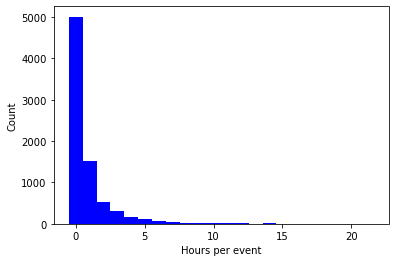

In [20]:
# Before merging data, analyze the lengths of the weather events.
weather_duration = weather_events.apply(
    lambda row: (row['EndTimeLocal'] - row['StartTimeLocal']).seconds/3600, axis=1)
longestEvent = max(weather_duration)
print('Longest weather event: %.1f hours' % longestEvent) # <24 hours. Good.
plt.hist(weather_duration, bins=int(longestEvent), color='b', align='left')
plt.xlabel('Hours per event')
plt.ylabel('Count')
plt.show() #Most events are < 2 hours, and almost all are < 8 hours.

In [21]:
# Organize events by date
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    weather_events['StartDate'] = weather_events.apply(lambda row: row['StartTimeLocal'].date(), axis=1)
    weather_events['EndDate'] = weather_events.apply(lambda row: row['EndTimeLocal'].date(), axis=1)
weather_starts = weather_events.copy()
weather_ends = weather_events.copy()
weather_starts = weather_starts.drop(['StartTimeLocal','EndTimeLocal','EndDate'], axis=1)
weather_ends = weather_ends.drop(['StartTimeLocal','EndTimeLocal','StartDate'], axis=1)

In [22]:
# Form a pivot table based on the highest precip code in each column per day.
weather_starts = pd.pivot_table(data=weather_starts, index=['Airport','StartDate'], aggfunc=np.max)
weather_ends = pd.pivot_table(data=weather_ends, index=['Airport','EndDate'], aggfunc=np.max)

# Append weather_starts and weather_ends (the columns are the same).
# We no longer need the weather_events DF, so name the result that.
weather_events = weather_starts.append(weather_ends).sort_index()

# Find the max over each date and rename the index. This is our final result for the weather data.
weather_events = pd.pivot_table(data=weather_events, index=['Airport','StartDate'], aggfunc=np.max)
weather_events.index.names = ['Airport','Date']
print(weather_events.head())

                    ColdCode  FogCode  HailCode  RainCode  SnowCode  StormCode
Airport Date                                                                  
ATL     2019-01-01         0      0.0         0       1.0       0.0          0
        2019-01-02         0      0.0         0       2.0       0.0          0
        2019-01-03         0      0.0         0       1.0       0.0          0
        2019-01-04         0      2.0         0       3.0       0.0          0
        2019-01-08         0      0.0         0       1.0       0.0          0


In [23]:
# Save the DataFrame and proceed to the flight_data.
# weather_events.to_csv('weather_events.csv') #Uncomment to create the file
print('Total runtime:', stopwatch.getElapsedTime())

Total runtime: --- 36.41 seconds ---
